In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib import font_manager
import re
import os
import matplotlib as mpl

/home/xurong_fan/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/xurong_fan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [165]:
class Dragome:
    @staticmethod
    # 读取 ClevaeLand 输出的信息文件以及整理的含保守结构域的 csv 文件
    def Read_result_file (result_file,Conserved_file):
        
        Outfile = result_file +".csv"
        print (f'Inputfile is {result_file} {Conserved_file}\nOutfile is {Outfile}')
        ## 读取含保守结构域的 csv 文件
        Conserved_df = pd.read_csv(Conserved_file,header=None,names=['Conserved_Gene','Conserved_start','Conserved_end'])
        
        ## 读取 ClevaeLand 输出的信息文件
        with open(result_file, 'r') as f:
            miRNA_pos = []  # 靶位点比对信息的列表
            Category = 0  # 存储 Category 行
            T_plot_message_file = ""  # 存储 T-Plot file行
            score = 0  # 存储分数
            Message = []  # 存储所有信息
            for line in f:
                if line.startswith("5'"):
                    ## 检测到 miRNA 切割信息,开始处理上一段的切割信息,并整理其他信息到列表中
                    if miRNA_pos:
                        miRNA_target = ''
                        Tr_seq = re.findall(r'(.*?)Transcript: (.*?):\d+-\d+', miRNA_pos[0])[0]
                        miRNA_pos[0] = Tr_seq[0]+Tr_seq[1]+'\n'
                        miRNA_seq = re.findall(r'(.*?)Query: (.*?)$', miRNA_pos[2])[0]
                        miRNA_pos[2] = miRNA_seq[0] + miRNA_seq[1]
                        miRNA_pos[2] = miRNA_seq[0]+miRNA_seq[1]
                        miRNA_target = miRNA_pos[0] + miRNA_pos[1] + miRNA_pos[2]
                        # print (miRNA_target)
                        Message.append([gene,miRNA,T_plot_message_file,score,Category,p_value,miRNA_target,T_plot_fig_message_file])
                    miRNA_pos = []  # 将前三行列表重置为空列表
                    miRNA_pos.append(line)  # 将当前行添加到前三行列表中

                elif miRNA_pos and len(miRNA_pos) < 3:  # 如果前三行列表非空且长度小于 3 ，则继续添加行至前三行列表中，获取完整的 miRNA 靶向序列
                    miRNA_pos.append(line)
                    
                    ## 提取 score
                elif (re.findall(r'Allen et al. score: (\d+(\.\d+)?)',line)):
                    score = float(re.findall(r'Allen et al. score: (\d+(\.\d+)?)',line)[0][0])
                    # print (score)
                    
                    ## 提取 Category
                elif (re.findall(r'Degardome Category: (\d?)',line)):
                    Category = int((re.findall(r'Degardome Category: (.\d?)',line)[0]))
                    # print (Category)
                    
                    ## 提取 p 值
                elif (re.findall(r'Degradome p-value: (.*\d.\d?)',line)):
                    p_value = float(re.findall(r'Degradome p-value: (.*\d.\d?)',line)[0])
                    p_value = round(p_value, 6)
                    #print (p_value)
                    
                    ## 提取绘图的数据文件,参考 CleaveLand4.pl 中 make_t_plot 函数进行修改
                elif (line.startswith("T-Plot file:")):
                    a = re.findall(r'(.*?).png',line)[0]
                    T_plot_message_file = os.path.basename(a) + '_tmp.txt'
                    T_plot_fig_message_file = os.path.basename(a) + '_draw.pdf'
                    # print (T_plot_message_file)
                    miRNA,gene,Site = line.strip().split('/')[1].split('_')[0:3]
                    ## 提取基因以及miRNA信息
                # elif (line.startswith("SiteID:")):
                #     _,gene,miRNA = line.strip().split(':')
                #     miRNA = 'miR' + miRNA
                #     gene = gene.strip()
            # 处理最后一个结构的前三行数据
            if miRNA_pos:
                Tr_seq = re.findall(r'(.*?)Transcript: (.*?):\d+-\d+', miRNA_pos[0])[0]
                miRNA_pos[0] = Tr_seq[0]+Tr_seq[1]+'\n'
                miRNA_seq = re.findall(r'(.*?)Query: (.*?)$', miRNA_pos[2])[0]
                miRNA_pos[2] = miRNA_seq[0] + miRNA_seq[1]
                miRNA_pos[2] = miRNA_seq[0]+miRNA_seq[1]
                miRNA_target = miRNA_pos[0] + miRNA_pos[1] + miRNA_pos[2]
            # print (miRNA_target)
            Message.append([gene,miRNA,T_plot_message_file,score,Category,p_value,miRNA_target,T_plot_fig_message_file])
        ## 生成信息矩阵
        Message_df = pd.DataFrame(Message)
        Message_df.columns=["gene","miRNA","T_plot_message_file","score","Category","p_value","miRNA_target","T_plot_fig_message_file"]
        Message_df.set_index("gene")
        ## 匹配保守结构域
        # Conserved_gene = set(Conserved_df['Conserved_Gene'])
        # for gene in Conserved_gene:
        #     Select_df = Conserved_df[Conserved_df['Conserved_Gene']==gene]
        #     Series = Message_df.loc[Message_df['gene']==gene]
        #     if Series.empty:
        #         continue
        #     for i in range(len(Select_df)):
        #         Conserved_start = f'Conserved{i+1}_start'
        #         Conserved_end = f'Conserved{i+1}_end'
        #         print (Series)
        #         Series.loc[:,Conserved_start] = Select_df.iloc[i]['Conserved_start']
        #         Message_df.loc[gene:,Conserved_end] = Select_df.iloc[i]['Conserved_end']
        #         Message_df.loc[Message_df['gene']==gene].Conserved_end = Select_df.iloc[i]['Conserved_end']
        #         Message_df.loc[Message_df['gene']==gene, Conserved_start] = Select_df.iloc[i]['Conserved_start']
        # Message_df.to_csv(Outfile,index=False)
        Conserved_gene = set(Conserved_df['Conserved_Gene'])
        for gene in Conserved_gene:
            Select_df = Conserved_df[Conserved_df['Conserved_Gene']==gene]
            if gene in Message_df['gene'].values:
                Series = Message_df.loc[Message_df['gene']==gene]
                if Series.empty:
                    continue
                for i in range(len(Select_df)):
                    Conserved_start = f'Conserved{i+1}_start'
                    Conserved_end = f'Conserved{i+1}_end'
                    Message_df.loc[Message_df['gene']==gene,Conserved_start] = Select_df.iloc[i]['Conserved_start']
                    Message_df.loc[Message_df['gene']==gene,Conserved_end] = Select_df.iloc[i]['Conserved_end']
        Message_df.to_csv(Outfile, index=False)
        return Message_df
    @staticmethod
    ## 绘图
    def Draw(Series):
        # 读取整理的数据
        mpl.rcParams['pdf.fonttype'] = 42
        mpl.rcParams['ps.fonttype'] = 42
        gene,miRNA,Draw_data_file,score,Category,p_value,miRNA_target,Save_fig,Conserved1_start,Conserved1_end,Conserved2_start,Conserved2_end = Series[0:12]
        data = pd.read_csv(Draw_data_file,sep='\t')
        ###################################################################################################
        ## 绘制 T-plot
        ax1 = plt.subplot2grid((14,12),(0,0),rowspan=8,colspan=6)
        ax1.plot(data['Position'], data['All'], color='black')
        # 获取切割位点 Site 所在的 Series
        df_notnan = data[~data['Site'].isna()]
        # 获取位点
        Site = df_notnan.iloc[0,0]
        # 获取位点切割分数
        Site_height = df_notnan.iloc[0,2]
        # 获取 y 轴长度
        y_len = plt.ylim()[1] - plt.ylim()[0]
        # 获取分数相对于 y 轴长度的比值，用于做图
        Site_len = float((Site_height-(plt.ylim()[0]))/(y_len))
        ax1.axvline(x=Site, color=(251/255,87/255,84/255), ymin=0,ymax=Site_len,linestyle='-')
        plt.xlabel('Transcript Position')
        plt.ylabel("Degradome 5' end Frequency")
        plt.title('Degradome Data')
        x_len = plt.xlim()[1] - plt.xlim()[0]
        ax1_annotation = 'Category=' + str(Category) + "\n" + 'P=' + str(p_value)
        plt.text(0.6,0.8,ax1_annotation,transform=ax1.transAxes,fontsize=10)
        print (x_len)
        ####################################################################################################
        ## 绘制保守结构域
        ax2 = plt.subplot2grid((14,12),(10,0),rowspan=1,colspan=6,sharex=ax1)
        ## 按照 CDS 长度绘制最下层的图
        rect1 = plt.Rectangle((0, 0), x_len, 0.5, facecolor=(240/255,90/255,217/255), alpha=0.5)
        ## 第一个结构域
        rect2 = plt.Rectangle((Conserved1_start, 0), (Conserved1_end-Conserved1_start), 0.5, facecolor=(255/255,217/255,48/255), alpha=0.5)
        ## 第二个结构域
        rect3 = plt.Rectangle((Conserved2_start, 0), (Conserved2_end-Conserved2_start), 0.5, facecolor=(255/255,217/255,48/255), alpha=0.5)
        ax2.add_patch(rect1)
        ax2.add_patch(rect2)
        ax2.add_patch(rect3)
        ## 隐藏坐标轴
        ax2.axis('off')
        ###################################################################################################
        ## 绘制miRNA的切割信息
        ax3 = plt.subplot2grid((14,12),(13,0),rowspan=1,colspan=6)
        ax3.text(0.1,-0.5,miRNA_target,fontproperties=font_manager.FontProperties(fname='/home/xurong_fan/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/consola.ttf'))
        ax3.axis('off')
        ###################################################################################################
        ## 绘制连接线
        xy = (Site, 0) 
        con = patches.ConnectionPatch( 
            xyA = xy, coordsA = ax2.transData, 
            xyB = xy, coordsB = ax1.transData, 
            linestyle="--", linewidth=1.5,edgecolor="red")
        ax2.add_artist(con) 
        text_xy = (0.5,3)
        con_text = patches.ConnectionPatch( 
            xyA = xy, coordsA = ax2.transData, 
            xyB = text_xy, coordsB = ax3.transData, 
            linestyle="--", linewidth=1.5,edgecolor="red")
        ax3.add_artist(con_text)
        final_xy = (0.5,1.5)
        con_final = patches.ConnectionPatch(xyA = text_xy, xyB = final_xy, 
                              coordsA=ax3.transData, coordsB=ax3.transData, arrowstyle="->", shrinkB=5,edgecolor="red")
        ax3.add_artist(con_final)
        # ax3.plot([xyA[0]], [xyA[1]], "o") 
        subtitle = f'{gene} -----> {miRNA}'
        plt.suptitle(subtitle,x=(8/12/2),y=1)
        plt.tight_layout()
        plt.savefig(Save_fig)
        print (f'Out Fig is {Save_fig}')

In [166]:
a = Dragome.Read_result_file('flower.txt','AP2_cds_cd_search.txt')

Inputfile is flower.txt AP2_cds_cd_search.txt
Outfile is flower.txt.csv


In [167]:
a.head(10)

,gene,miRNA,T_plot_message_file,score,Category,p_value,miRNA_target,T_plot_fig_message_file,Conserved1_start,Conserved1_end,Conserved2_start,Conserved2_end
0,LITCHI000053.m1,miR2275a,miR2275a_LITCHI000053.m1_271_TPlot_tmp.txt,17.5,2,0.466493,5' GAAGGUACAGGAGGGUUCAUUGAGCCAAA 3' LITCHI0000...,miR2275a_LITCHI000053.m1_271_TPlot_draw.pdf,NaN,NaN,NaN,NaN
1,LITCHI000182.m2,miR482a,miR482a_LITCHI000182.m2_130_TPlot_tmp.txt,10.0,2,0.997482,5' GCGGCGU-GGUGGUGUUGGAGA 3' LITCHI000182.m2\n...,miR482a_LITCHI000182.m2_130_TPlot_draw.pdf,NaN,NaN,NaN,NaN
2,LITCHI000182.m2,miR482e,miR482e_LITCHI000182.m2_132_TPlot_tmp.txt,5.0,4,0.995012,5' GGCGUGGU-GGUGUUGGAGAGG 3' LITCHI000182.m2\n...,miR482e_LITCHI000182.m2_132_TPlot_draw.pdf,NaN,NaN,NaN,NaN
3,LITCHI000182.m2,miR827,miR827_LITCHI000182.m2_1355_TPlot_tmp.txt,9.0,2,0.967423,5' AGGAUGUUGGUAGGUCAUCUUC 3' LITCHI000182.m2\n...,miR827_LITCHI000182.m2_1355_TPlot_draw.pdf,NaN,NaN,NaN,NaN
4,LITCHI000184.m2,miR482a,miR482a_LITCHI000184.m2_695_TPlot_tmp.txt,7.0,4,0.998712,5' GAGGCAUGGUUGGAGGUGGCAG 3' LITCHI000184.m2\n...,miR482a_LITCHI000184.m2_695_TPlot_draw.pdf,NaN,NaN,NaN,NaN
5,LITCHI000184.m4,miR482a,miR482a_LITCHI000184.m4_614_TPlot_tmp.txt,7.0,0,0.064261,5' GAGGCAUGGUUGGAGGUGGCAG 3' LITCHI000184.m4\n...,miR482a_LITCHI000184.m4_614_TPlot_draw.pdf,NaN,NaN,NaN,NaN
6,LITCHI000184.m5,miR482a,miR482a_LITCHI000184.m5_695_TPlot_tmp.txt,7.0,2,0.930762,5' GAGGCAUGGUUGGAGGUGGCAG 3' LITCHI000184.m5\n...,miR482a_LITCHI000184.m5_695_TPlot_draw.pdf,NaN,NaN,NaN,NaN
7,LITCHI000185.m1,miR395e,miR395e_LITCHI000185.m1_829_TPlot_tmp.txt,6.0,4,0.999999,5' CAGUUGCUCCAAGCUCUUCAC 3' LITCHI000185.m1\n ...,miR395e_LITCHI000185.m1_829_TPlot_draw.pdf,NaN,NaN,NaN,NaN
8,LITCHI000185.m2,miR395e,miR395e_LITCHI000185.m2_1186_TPlot_tmp.txt,6.0,4,0.999999,5' CAGUUGCUCCAAGCUCUUCAC 3' LITCHI000185.m2\n ...,miR395e_LITCHI000185.m2_1186_TPlot_draw.pdf,NaN,NaN,NaN,NaN
9,LITCHI000186.m1,miR156a,miR156a_LITCHI000186.m1_644_TPlot_tmp.txt,5.0,4,0.674392,5' CUUGCUCUCUCUCUCUUGUCC 3' LITCHI000186.m1\n ...,miR156a_LITCHI000186.m1_644_TPlot_draw.pdf,NaN,NaN,NaN,NaN


In [178]:
Select_df = a[ (a['score']<=5) & (a['Category']<=2)]

In [185]:
Select_df = Select_df.reset_index(drop=True)

24
95
162
201
24
1655.5


/tmp/ipykernel_82729/2516540434.py:179: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
MERG NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


Out Fig is miR172a_LITCHI006915.m1_1423_TPlot_draw.pdf
95
1576.3000000000002


/tmp/ipykernel_82729/2516540434.py:179: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
MERG NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


Out Fig is miR172a_LITCHI018533.m1_1291_TPlot_draw.pdf
162
1705.0


/tmp/ipykernel_82729/2516540434.py:179: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
MERG NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


Out Fig is miR172a_LITCHI024773.m2_1390_TPlot_draw.pdf
201
1655.5


/tmp/ipykernel_82729/2516540434.py:179: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
MERG NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


Out Fig is miR172a_LITCHI027926.m1_1375_TPlot_draw.pdf


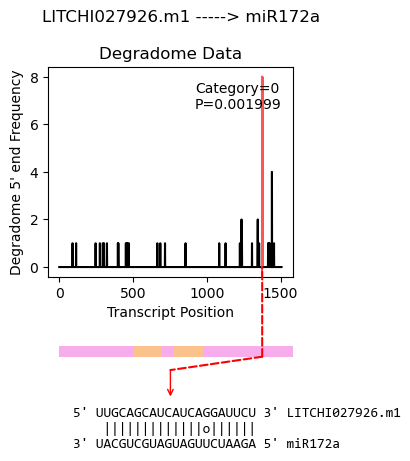

In [186]:
Select_gene = set(Select_df['gene'])
Target_df = pd.DataFrame
Target_gene =[]
with open ('Lch.id','r') as f:
    for line in f:
        gene = line.strip()
        for index, row in Select_df.iterrows():
            if row['gene']  == gene:
                Target_gene.append(index)
                print (index)
for index in Target_gene:
    print (index)
    Series = Select_df.iloc[index,:]
    Dragome.Draw(Series)

In [182]:
Select_df.iloc[392]

IndexError: single positional indexer is out-of-bounds

In [36]:
df = pd.read_csv('/home/xurong_fan/AP2/Last_data/dapseq/Macs2_low_value_Test/ReWriteCallPeak/test/PandaStudy/datas/beijing_tianqi/beijing_tianqi_2018.csv')
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel
0,2018-01-01,3℃,-6℃,晴~多云,东北风,1-2级,59,良,2
1,2018-01-02,2℃,-5℃,阴~多云,东北风,1-2级,49,优,1
2,2018-01-03,2℃,-5℃,多云,北风,1-2级,28,优,1
3,2018-01-04,0℃,-8℃,阴,东北风,1-2级,28,优,1
4,2018-01-05,3℃,-6℃,多云~晴,西北风,1-2级,50,优,1


In [39]:
df.loc['2018-01-03',:]

KeyError: '2018-01-03'